In [5]:
import pandas as pd
import numpy as np
import pickle
import datatable as dt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score, median_absolute_error
import seaborn as sns



In [6]:
def read_feature_matrix() -> pd.DataFrame:
    feature_matrix = None
    with open('Preprocessed/feature_matrix_sparse.pkl', 'rb') as f:
        feature_matrix = pickle.load(f)
    
    feature_matrix = pd.DataFrame(feature_matrix.todense(),dtype="uint8")

    with open('Preprocessed/feature_matrix_columns.pkl', 'rb') as f:
        feature_matrix_columns = pickle.load(f)

    feature_matrix.columns = feature_matrix_columns
    return feature_matrix


In [7]:
pp_meals = pd.read_csv('Preprocessed/processed_meals.csv')
pp_interactions = pd.read_csv('Preprocessed/processed_interactions.csv')
feature_matrix = read_feature_matrix()
feature_matrix
# feature_matrix = pd.read_csv('Preprocessed/feature_matrix_with_titles.csv', dtype=np.uint8)
# feature_matrix


,lettuce,french vanilla pudding and pie filling mix,stove top stuffing mix,cream cheese,cheddar,radicchio,pasta sauce,tomato sauce,shredded three cheese,mozzarella,...,broccolini,risoni,rapini,chapatus,broccoflower,soybean,goose,ajwain,brinjal,khoya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178261,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178262,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
user_id = pp_interactions['user_id'].value_counts().idxmax()
pp_interactions = pp_interactions.loc[pp_interactions['user_id'] == user_id].reset_index(drop=True)

In [9]:
rated_meals = feature_matrix.iloc[pp_interactions['recipe_id']]
# convert index to recipe_id in another column
rated_meals['recipe_id'] = feature_matrix.iloc[pp_interactions['recipe_id']].index
rated_meals = rated_meals.reset_index(drop=True)
# add rating column
rated_meals['rating'] = pp_interactions['rating']
rated_meals

C:\Users\hazem\AppData\Local\Temp\ipykernel_11056\13657870.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_meals['recipe_id'] = feature_matrix.iloc[pp_interactions['recipe_id']].index


,lettuce,french vanilla pudding and pie filling mix,stove top stuffing mix,cream cheese,cheddar,radicchio,pasta sauce,tomato sauce,shredded three cheese,mozzarella,...,rapini,chapatus,broccoflower,soybean,goose,ajwain,brinjal,khoya,recipe_id,rating
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4226,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,67852,5
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,104194,4
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,8498,5
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,151585,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,155019,5
6433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,135930,5
6434,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,121145,5
6435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,114226,5


In [10]:
# split rated meals into train and test
train, validation = train_test_split(rated_meals, train_size=0.7, test_size=0.3, random_state=42)
# extract x_train, y_train, x_validation, y_validation by dropping recipe_id and rating columns
x_train = train.drop(['recipe_id', 'rating'], axis=1)
y_train = train['rating']
x_validation = validation.drop(['recipe_id', 'rating'], axis=1)
y_validation = validation['rating']

In [11]:
# train linear regression model
model = GradientBoostingRegressor(
    n_estimators = 4780, 
    learning_rate = 0.01,
    max_depth = 10, 
    max_features = 'sqrt',
    min_samples_leaf = 1, 
    min_samples_split = 250, 
    loss = 'squared_error', 
    random_state = 6
)
model.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, max_features='sqrt',
                          min_samples_split=250, n_estimators=4780,
                          random_state=6)

In [12]:
y_pred = model.predict(x_validation)

rmse = mean_squared_error(y_validation, y_pred, squared=False)
r2 = r2_score(y_validation, y_pred)
explained_variance = explained_variance_score(y_validation, y_pred)

# misclassified examples after rounding the predictions
misclassified = (y_validation.to_numpy().astype(np.float64) != np.round(y_pred)).sum()
accuracy = 1 - (misclassified / len(y_validation))

print('RMSE: ', rmse)
print('R2: ', r2)
print('Explained Variance: ', explained_variance)
print('Misclassified: ', misclassified)
print('Accuracy: ', accuracy)


RMSE:  0.2589936981058805
R2:  -0.24753839630484364
Explained Variance:  -0.24721804513360568
Misclassified:  68
Accuracy:  0.9648033126293996


In [13]:
# save model as pickle file
pickle.dump(model, open('Models/content_based_model.pkl', 'wb'))

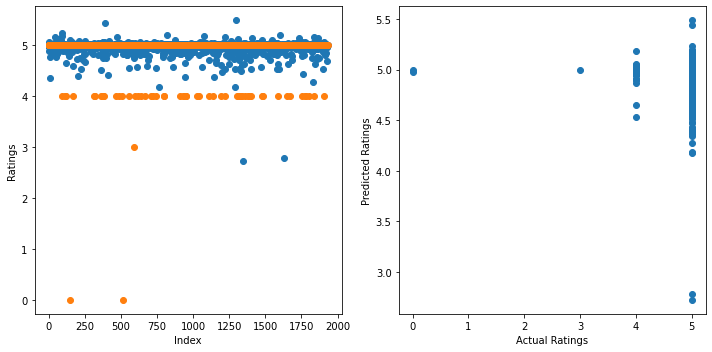

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x=range(y_pred.shape[0]), y=y_pred, label='Predicted Ratings')
plt.scatter(x=range(y_validation.shape[0]), y=y_validation, label='Actual Ratings')
plt.xlabel('Index')
plt.ylabel('Ratings')
plt.subplot(1, 2, 2)
plt.scatter(x=y_validation, y=y_pred)
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.tight_layout()

---

Model use

In [15]:
unrated_meals = feature_matrix.iloc[~feature_matrix.index.isin(pp_interactions['recipe_id'])]
unrated_meals_ids = unrated_meals.index
unrated_meals

,lettuce,french vanilla pudding and pie filling mix,stove top stuffing mix,cream cheese,cheddar,radicchio,pasta sauce,tomato sauce,shredded three cheese,mozzarella,...,broccolini,risoni,rapini,chapatus,broccoflower,soybean,goose,ajwain,brinjal,khoya
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178261,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178262,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178263,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
model = pickle.load(open('Models/content_based_model.pkl', 'rb'))

In [17]:
# convert csr_matrix to numpy array
# x_test = unrated_meals.toarray()
# add column names
# x_test = pd.DataFrame(x_test, columns=feature_matrix.columns)
x_test = unrated_meals
y_pred_test = model.predict(x_test)
y_pred_test

array([4.99755251, 4.71472721, 5.01689609, ..., 5.00601099, 4.98534795,
       5.01045284])

In [18]:
y_pred_test.shape

(171828,)

In [19]:
# convert y_pred to be a tuple of y_pred and of recipe_id
unrated_lst = list(zip(y_pred_test, unrated_meals_ids))
unrated_lst.sort(key=lambda x: x[0], reverse=True)
unrated_lst

[(5.9141254920312845, 72761),
 (5.905259969079386, 75949),
 (5.843729934338455, 50975),
 (5.553171691480146, 156063),
 (5.535577806945313, 132866),
 (5.531325322963995, 50388),
 (5.531206757675489, 163345),
 (5.530543039939637, 127695),
 (5.526238858274423, 111307),
 (5.525019014538486, 47676),
 (5.523403459563525, 91139),
 (5.5215291680206, 22491),
 (5.520620615898579, 118815),
 (5.519244895074573, 51079),
 (5.517902998958724, 53560),
 (5.517266673361787, 156958),
 (5.516663885235937, 46887),
 (5.51653685220526, 71046),
 (5.511948883080915, 170571),
 (5.511603634303996, 27533),
 (5.511290955273427, 64271),
 (5.510383721087403, 109160),
 (5.51016831063339, 86820),
 (5.5089442370706925, 170895),
 (5.508744613343984, 149560),
 (5.508605254476063, 67725),
 (5.508105236389523, 159130),
 (5.5077761357819, 150485),
 (5.507184872067929, 132914),
 (5.507106862963957, 52156),
 (5.50627077525106, 27227),
 (5.505621415064206, 135860),
 (5.505526677472938, 124636),
 (5.505513071200112, 3740),
 (5.

In [20]:
# get top 10 recommendations by mapping Ids to rows in pp_meals
top_10_recommendations = pp_meals.iloc[[x[1] for x in unrated_lst[:10]]]
top_10_recommendations

,id,calorie_level,replaced_ingredients,name,minutes,nutrition,steps,ingredients
72761,183977,1,"['ground sirloin', 'shallot', 'whole grain dij...",best beef burgers,31,"[460.3, 38.0, 11.0, 19.0, 67.0, 48.0, 7.0]","['in a big bowl , blend all the ingredients to...","['ground sirloin', 'shallot', 'whole grain dij..."
75949,231258,2,"['ground sirloin', 'worcestershire sauce', 'ga...",savory herb marinated burgers,60,"[563.6, 38.0, 39.0, 37.0, 72.0, 53.0, 15.0]","['form hamburger into 4 patties', 'in a bowl o...","['ground sirloin', 'worcestershire sauce', 'ga..."
50975,481945,0,"['floury potato', 'avocado oil', 'fresh rosema...",best ever roast potatoes,65,"[250.0, 21.0, 8.0, 1.0, 6.0, 8.0, 9.0]","['preheat oven to 190c / 375f / gas mark 5 , o...","['floury potatoes', 'avocado oil', 'fresh rose..."
156063,428639,2,"['olive oil', 'israeli couscou', 'chicken brot...",couscous with apples cranberries and herbs,40,"[687.7, 44.0, 50.0, 12.0, 38.0, 19.0, 29.0]","['in a medium saucepan , heat the olive oil on...","['olive oil', 'israeli couscous', 'low sodium ..."
132866,282743,1,"['butter', 'mushroom cap', 'shallot', 'salt & ...",mushrooms in cognac herb sauce,190,"[445.6, 69.0, 8.0, 5.0, 11.0, 139.0, 2.0]","['in a large skillet , saute shallots and mush...","['butter', 'mushroom caps', 'shallots', 'salt ..."
50388,58326,1,"['red bell pepper', 'onion', 'garlic', 'fresh ...",mediterranean lamb and couscous stuffed bell p...,50,"[478.0, 26.0, 35.0, 18.0, 43.0, 36.0, 19.0]",['slice peppers in half lengthwise through the...,"['red bell peppers', 'onions', 'garlic', 'fres..."
163345,77496,2,"['leg of lamb', 'olive oil', 'dijon mustard', ...",leg of lamb crusted herbed with roasted garli...,65,"[1506.5, 176.0, 2.0, 28.0, 207.0, 229.0, 1.0]",['in a roasting pan with very hot extra-virgin...,"['boneless leg of lamb', 'extra virgin olive o..."
127695,108195,0,"['salmon fillet', 'garlic', 'fresh thyme', 'fr...",broiled salmon with herb mustard glaze,19,"[246.0, 15.0, 1.0, 10.0, 70.0, 8.0, 0.0]","['in a mini food processor , combine garlic , ...","['salmon fillets', 'garlic', 'fresh thyme', 'f..."
111307,474359,1,"['red bell pepper', 'black pepper', 'beef brot...",lebanese stuffed peppers,110,"[279.3, 17.0, 27.0, 15.0, 40.0, 19.0, 7.0]","['preheat oven to 400 degrees', 'cut tops off ...","['red bell peppers', 'black pepper', 'low sodi..."
47676,99956,1,"['cooking spray', 'salmon fillet', 'salt', 'bl...",orange rosemary salmon,40,"[297.8, 12.0, 31.0, 14.0, 91.0, 6.0, 2.0]",['pre-heat oven to 350:f and spray casserole d...,"['canola oil cooking spray', 'salmon fillets',..."
